In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def seed_all(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [2]:
x = torch.tensor([1.5])
w = torch.tensor([0.2], requires_grad=True)
w.grad

y = torch.tensor([0.5])

yhat = x * w
loss = (yhat - y)**2

# loss.grad_fn.next_functions[0][0].next_functions

In [3]:
optimizer = optim.SGD([w], lr=0.01)
optimizer.step()
optimizer.zero_grad()

In [4]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

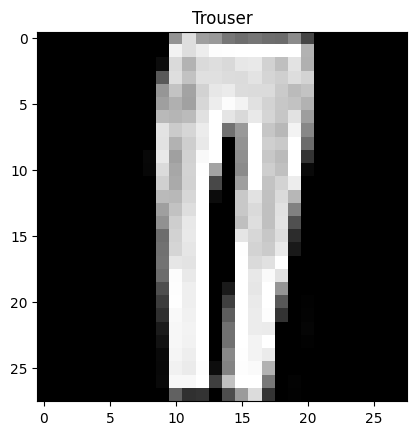

In [5]:
data = pd.read_csv('data/fashionmnist_train.csv').to_numpy()
idx = np.random.randint(0, data.shape[0])
plt.imshow(data[idx, 1:].reshape(28, 28), cmap='gray')
plt.title(classes[data[idx, 0]])
plt.show()

In [6]:
class myDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file).to_numpy()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the label and features
        label = self.data[idx, 0]
        features = self.data[idx, 1:] / 255
        # print(features.shape)

        return features, label

In [7]:
dataset_train = myDataset('data/fashionmnist_train.csv')
dataset_test = myDataset('data/fashionmnist_test.csv')

loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [8]:
for x,y in loader_train:
    print(x.shape)
    break

torch.Size([32, 784])


In [9]:
len(dataset_train), len(dataset_test)

(5000, 1000)

In [10]:
class MLP(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device

        # Define our layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

        self.to(device=device)

    def forward(self, x):
        # Define the forward pass of our model
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def Train(self, epochs, optimizer, loader_train, loader_test, verbose=True):
        
        self.loss_train_log = []
        self.loss_test_log = []
        self.best_loss = np.inf
        
        for epoch in range(epochs):
            self.train() # need to specify as certain layers (e.g. dropout) behave differently in train/eval
            
            # in every epoch, we will:
            # (1) loop over loader_train to train the model
            # (2) calculate the loss of training data and save it (for loss curve)
            # (3) calculate the loss of val/testing data and save it (for loss curve)
            # (4) print training progress
            # (5) early stopping

            # Step (1)        
            for x, y in loader_train:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.long) # label is torch.float if regression, torch.long if classification

                # Reset the gradients
                optimizer.zero_grad() # SOLUTION

                # Forward pass and calculate loss
                yhat = self.forward(x) # SOLUTION
                loss = F.cross_entropy(yhat, y) # SOLUTION

                # Backward pass and update weights
                loss.backward() # SOLUTION
                optimizer.step() # SOLUTION

            # Step (2) (need to complete the self.evaluate function to work)
            loss_train = self.evaluate(loader_train) # SOLUTION
            self.loss_train_log.append(loss_train) # SOLUTION

            # Step (3) (need to complete the self.evaluate function to work)
            loss_test = self.evaluate(loader_test) # SOLUTION
            self.loss_test_log.append(loss_test) # SOLUTION

            # Step (4)
            if verbose:
                print('Epochs %d/%d' % (epoch+1, epochs))
                print('Train Loss = %.4f' % loss_train, end=', ')
                print('Val Loss = %.4f' % loss_test)

            # Step (5)
            if loss_test < self.best_loss:
                self.best_loss = loss_test
                best_epoch = epoch + 1
                torch.save(self.state_dict(), 'best_params.pt')
        
        print(f'Best model saved at epoch {best_epoch} with loss {self.best_loss:.4f}.')

    def evaluate(self, loader):
        # this function is to evaluate the model on a given dataset (loader) by computing the average loss

        self.eval() # need to specify as certain layers (e.g. dropout) behave differently in train/eval
        
        loss = 0
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.long) # label is torch.float if regression, torch.long if classification

                # forward pass and calculate loss
                yhat = self.forward(x) # SOLUTION
                loss += F.cross_entropy(yhat, y, reduction='sum') # SOLUTION
        
        loss /= len(loader.dataset)
        return loss.cpu()
    
    def predict(self, loader):
        # this function is to provide the model's prediction on a given dataset (loader).
        # it returns the prediction, together with the corresponding input x and label y (for evaluation/visualization purposes)
        
        self.eval() # need to specify as certain layers (e.g. dropout) behave differently in train/eval

         # SOLUTION
        x_all, y_all, pred = [], [], []
        with torch.no_grad():
            for x, y in loader:
                x_all.append(x)
                y_all.append(y)

                x = x.to(device=self.device, dtype=torch.float)
                yhat = self.forward(x) # SOLUTION
                pred.append(yhat.cpu())
                
            x_all, y_all, pred = torch.cat(x_all), torch.cat(y_all), torch.cat(pred)
            return x_all, y_all, pred

In [11]:
# T1.3 IMPORTANT: Please do not edit/remove this comment.

lr = 0.01
epochs = 20
model = MLP(device=device)
optimizer = optim.Adam(model.parameters(), lr=lr)
model.Train(epochs, optimizer, loader_train, loader_test)

Epochs 1/20
Train Loss = 0.7134, Val Loss = 0.7131
Epochs 2/20
Train Loss = 0.5238, Val Loss = 0.5791
Epochs 3/20
Train Loss = 0.4580, Val Loss = 0.5159
Epochs 4/20
Train Loss = 0.4160, Val Loss = 0.4831
Epochs 5/20
Train Loss = 0.4639, Val Loss = 0.6110
Epochs 6/20
Train Loss = 0.4715, Val Loss = 0.6084
Epochs 7/20
Train Loss = 0.3793, Val Loss = 0.5000
Epochs 8/20
Train Loss = 0.3789, Val Loss = 0.5021
Epochs 9/20
Train Loss = 0.3760, Val Loss = 0.5293
Epochs 10/20
Train Loss = 0.3829, Val Loss = 0.5374
Epochs 11/20
Train Loss = 0.3373, Val Loss = 0.5046
Epochs 12/20
Train Loss = 0.2929, Val Loss = 0.5028
Epochs 13/20
Train Loss = 0.3437, Val Loss = 0.5071
Epochs 14/20
Train Loss = 0.2617, Val Loss = 0.4681
Epochs 15/20
Train Loss = 0.2850, Val Loss = 0.5669
Epochs 16/20
Train Loss = 0.2532, Val Loss = 0.4666
Epochs 17/20
Train Loss = 0.3802, Val Loss = 0.6242
Epochs 18/20
Train Loss = 0.2334, Val Loss = 0.4554
Epochs 19/20
Train Loss = 0.2410, Val Loss = 0.5228
Epochs 20/20
Train Lo

#### (a) Inspecting the loss

In the model class, there are two variables `self.loss_train_log` and `self.loss_test_log` which record the historical losses as the training progresses. Plot both the losses in the same figure to visualize the training progress, and ensure that proper labels and legend are in-place.

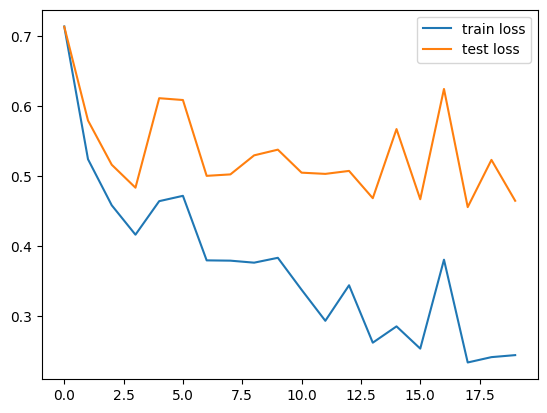

In [12]:
# T1.4a IMPORTANT: Please do not edit/remove this comment.

# Plot the losses in the same figure
plt.plot(model.loss_train_log)
plt.plot(model.loss_test_log)
plt.legend(['train loss', 'test loss'])

In [13]:
# T1.4b IMPORTANT: Please do not edit/remove this comment.

x_all, y_all, pred = model.predict(loader_test)
(F.softmax(pred, dim=1).argmax(dim=1) == y_all).sum()/len(y_all)

tensor(0.8500)

In [14]:
best_params = torch.load('best_params.pt')
model_best = MLP(device=device)
model_best.load_state_dict(best_params)
x_all, y_all, pred = model_best.predict(loader_test)
(F.softmax(pred, dim=1).argmax(dim=1) == y_all).sum()/len(y_all)

tensor(0.8480)

In [15]:
# CNN

In [16]:
# The Compose function allows you to combine multiple image transformations into a sequential pipeline. 
# Each transformation will be applied in the order they appear within the list.
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally (left to right)
    transforms.RandomRotation(10), # Apply a random rotation of +-10 degrees to each image
    transforms.ToTensor(), # Convert the image to a PyTorch tensor in the range of [0,1]
    transforms.Normalize(mean=[0.5,], std=[0.5,]), # Normalise the image tensor with mean and standard deviation values of 0.5 for each channel
])

# Augmentation is not applied to test data
transform_test = transforms.Compose([
    transforms.ToTensor(), # Convert the image to a PyTorch tensor in the range of [0,1]
    transforms.Normalize(mean=[0.5,], std=[0.5,]), # Normalise the image tensor with mean and standard deviation values of 0.5 for each channel
])

In [17]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file).to_numpy()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the label and features
        label = self.data[idx, 0]
        image = self.data[idx, 1:].reshape(28, 28, 1) / 255

        if self.transform:
            image = self.transform(image)

        return image, label

In [18]:
dataset_train = FashionMNISTDataset('data/fashion-mnist_train.csv', transform=transform_train)
dataset_test = FashionMNISTDataset('data/fashion-mnist_test.csv', transform=transform_test)

loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: 'data/fashion-mnist_train.csv'

In [ ]:
class CNN(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device

        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.AvgPool2d(kernel_size=7)

        # Fully connected layer(s)
        self.fc = nn.Linear(64 * 1 * 1, 10)  # After 3 pooling layers on 28x28 input, spatial dims are 3x3

        self.to(device=device)  

    def forward(self, x):
        # Conv Block 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        # Conv Block 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        # Conv Block 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        # Flatten for FC layers
        x = x.view(x.size(0), -1)  # Flatten

        # Fully connected layers
        x = self.fc(x)

        return x
    
    def Train(self, epochs, optimizer, loader_train, loader_test, verbose=True):
        self.loss_train_log = []
        self.loss_test_log = []
        best_loss = np.inf
        for epoch in range(epochs):
            self.train() # need to specify as certain layers (e.g. dropout) behave differently in train/eval
            
            # in every epoch, we will:
            # (1) loop over loader_train to train the model
            # (2) calculate the loss of training data and save it (for loss curve)
            # (3) calculate the loss of val/testing data and save it (for loss curve)
            # (4) print training progress
            # (5) early stopping

            # Step (1)        
            for x, y in loader_train:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.long) # label is torch.float if regression, torch.long if classification

                # Reset the gradients
                optimizer.zero_grad() # SOLUTION

                # Forward pass and calculate loss
                yhat = self.forward(x) # SOLUTION
                loss = F.cross_entropy(yhat, y) # SOLUTION

                # Backward pass and update weights
                loss.backward() # SOLUTION
                optimizer.step() # SOLUTION

            # Step (2) (need to complete the self.evaluate function to work)
            loss_train = self.evaluate(loader_train) # SOLUTION
            self.loss_train_log.append(loss_train) # SOLUTION

            # Step (3) (need to complete the self.evaluate function to work)
            loss_test = self.evaluate(loader_test) # SOLUTION
            self.loss_test_log.append(loss_test) # SOLUTION

            # Step (4)
            if verbose:
                print('Epochs %d/%d' % (epoch+1, epochs))
                print('Train Loss = %.4f' % loss_train, end=', ')
                print('Val Loss = %.4f' % loss_test)

            # Step (5)
            if loss_test < best_loss:
                best_loss = loss_test
                best_epoch = epoch + 1
                torch.save(self.state_dict(), 'best_params.pt')
        
        print(f'Best model saved at epoch {best_epoch} with loss {best_loss:.4f}.')

    def evaluate(self, loader):
        # this function is to evaluate the model on a given dataset (loader) by computing the average loss

        self.eval() # need to specify as certain layers (e.g. dropout) behave differently in train/eval
        
        loss = 0
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.long) # label is torch.float if regression, torch.long if classification

                # forward pass and calculate loss
                yhat = self.forward(x) # SOLUTION
                loss += F.cross_entropy(yhat, y, reduction='sum') # SOLUTION
        
        loss /= len(loader.dataset)
        return loss.cpu()
    
    def predict(self, loader):
        # this function is to provide the model's prediction (and the corresponding ground truth) on a given dataset (loader).
        # both actual and pred should be arrays of shape (m,1) where m is the number of samples.
        
        self.eval() # need to specify as certain layers (e.g. dropout) behave differently in train/eval

         # SOLUTION
        x_all, y_all, pred = [], [], []
        with torch.no_grad():
            for x, y in loader:
                x_all.append(x)
                y_all.append(y)

                x = x.to(device=self.device, dtype=torch.float)
                yhat = self.forward(x) # SOLUTION
                pred.append(yhat.cpu())
            
            x_all, y_all, pred = torch.cat(x_all), torch.cat(y_all), torch.cat(pred)
            return x_all, y_all, pred

In [ ]:

lr = 0.01
epochs = 20
model = CNN(device=device)
optimizer = optim.Adam(model.parameters(), lr=lr)
model.Train(epochs, optimizer, loader_train, loader_test)

In [ ]:
# T1.4a IMPORTANT: Please do not edit/remove this comment.

# Plot the losses in the same figure
plt.plot(model.loss_train_log)
plt.plot(model.loss_test_log)
plt.legend(['train loss', 'test loss'])

In [ ]:
# T1.4b IMPORTANT: Please do not edit/remove this comment.

x_all, y_all, pred = model.predict(loader_test)
(F.softmax(pred, dim=1).argmax(dim=1) == y_all).sum()/len(y_all)

In [ ]:
best_params = torch.load('best_params.pt')
model_best = CNN()
model_best.load_state_dict(best_params)
x_all, y_all, pred = model_best.predict(loader_test)
(F.softmax(pred, dim=1).argmax(dim=1) == y_all).sum()/len(y_all)